In [521]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [522]:
# loading data
df = pd.read_csv("Algerian_forest_fires_cleaned.csv")
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


# Meta data
* Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012) Weather data observations
* Temp : temperature noon (temperature max) in Celsius degrees
* RH : Relative Humidity in %
* Ws :Wind speed in km/h
* Rain: total day in mm FWI Components
* Fine Fuel Moisture Code (FFMC) index from the FWI system
* Duff Moisture Code (DMC) index from the FWI system
* Drought Code (DC) index from the FWI system
* Initial Spread Index (ISI) index from the FWI system
* Buildup Index (BUI) index from the FWI system
* Fire Weather Index (FWI) Index
* Classes: two classes, namely Fire and not Fire

In [523]:
# information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day          243 non-null    int64  
 1   month        243 non-null    int64  
 2   year         243 non-null    int64  
 3   Temperature  243 non-null    int64  
 4   RH           243 non-null    int64  
 5   Ws           243 non-null    int64  
 6   Rain         243 non-null    float64
 7   FFMC         243 non-null    float64
 8   DMC          243 non-null    float64
 9   DC           243 non-null    float64
 10  ISI          243 non-null    float64
 11  BUI          243 non-null    float64
 12  FWI          243 non-null    float64
 13  Classes      243 non-null    object 
 14  Region       243 non-null    int64  
dtypes: float64(7), int64(7), object(1)
memory usage: 28.6+ KB


In [524]:
# check for total null value count
df.isnull().sum()

,0
day,0
month,0
year,0
Temperature,0
RH,0
Ws,0
Rain,0
FFMC,0
DMC,0
DC,0


In [525]:
df.shape

(243, 15)

In [526]:
# Data Cleaning

In [527]:
df.columns

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [528]:
df.Classes.unique()

array(['not fire   ', 'fire   ', 'fire', 'fire ', 'not fire', 'not fire ',
       'not fire     ', 'not fire    '], dtype=object)

In [529]:
df.year.unique()

array([2012])

In [530]:
# since there is recond for only one year which is not significant, so dropping a column year
df = df.drop(columns=['year'])

In [531]:
df["month"].unique()

array([6, 7, 8, 9])

In [532]:
# convert class names by removing spaces
df['Classes'] = df['Classes'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [533]:
df.Classes.unique()

array(['not fire', 'fire'], dtype=object)

In [534]:
# check for the missing values
df[df.isnull().any(axis=1)]

,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region


In [535]:
# check for the null values for each of the columns
df.isnull().sum()

,0
day,0
month,0
Temperature,0
RH,0
Ws,0
Rain,0
FFMC,0
DMC,0
DC,0
ISI,0


In [536]:
def clean_column_name(df):
    """
    Function to convert all column names in a DataFrame to lowercase and stripped of leading/trailing spaces.

    Args:
    df (pd.DataFrame): The DataFrame whose column names need to be cleaned.

    Returns:
    pd.DataFrame: DataFrame with cleaned column names.
    """
    df.columns = [col.strip().upper() for col in df.columns]
    return df

df = clean_column_name(df)

In [537]:
df

,DAY,MONTH,TEMPERATURE,RH,WS,RAIN,FFMC,DMC,DC,ISI,BUI,FWI,CLASSES,REGION
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,1
239,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,1
240,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
241,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [538]:
data=df.copy()

In [539]:
data.head()

,DAY,MONTH,TEMPERATURE,RH,WS,RAIN,FFMC,DMC,DC,ISI,BUI,FWI,CLASSES,REGION
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0


In [540]:
# changeing the datatype of the columns month, day,year,temperature, TH, and Ws
data[['MONTH','DAY','TEMPERATURE','RH','WS']]=data[['MONTH','DAY','TEMPERATURE','RH','WS']].astype(int)

In [541]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAY          243 non-null    int64  
 1   MONTH        243 non-null    int64  
 2   TEMPERATURE  243 non-null    int64  
 3   RH           243 non-null    int64  
 4   WS           243 non-null    int64  
 5   RAIN         243 non-null    float64
 6   FFMC         243 non-null    float64
 7   DMC          243 non-null    float64
 8   DC           243 non-null    float64
 9   ISI          243 non-null    float64
 10  BUI          243 non-null    float64
 11  FWI          243 non-null    float64
 12  CLASSES      243 non-null    object 
 13  REGION       243 non-null    int64  
dtypes: float64(7), int64(6), object(1)
memory usage: 26.7+ KB


In [542]:
# statistical summary
data.describe()

,DAY,MONTH,TEMPERATURE,RH,WS,RAIN,FFMC,DMC,DC,ISI,BUI,FWI,REGION
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,15.761317,7.502058,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,7.035391,0.497942
std,8.842552,1.114793,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,7.440568,0.501028
min,1.000000,6.000000,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000,0.000000
25%,8.000000,7.000000,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,0.700000,0.000000
50%,16.000000,8.000000,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,4.200000,0.000000
75%,23.000000,8.000000,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,11.450000,1.000000
max,31.000000,9.000000,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000,1.000000


In [543]:
# encode class: not fire:0 and fire:1
data["CLASSES"] = np.where(data["CLASSES"].str.contains("not fire"), 0, 1)

In [544]:
# check if encodeing is as intended
df["CLASSES"].value_counts()

,count
CLASSES,
fire,137
not fire,106


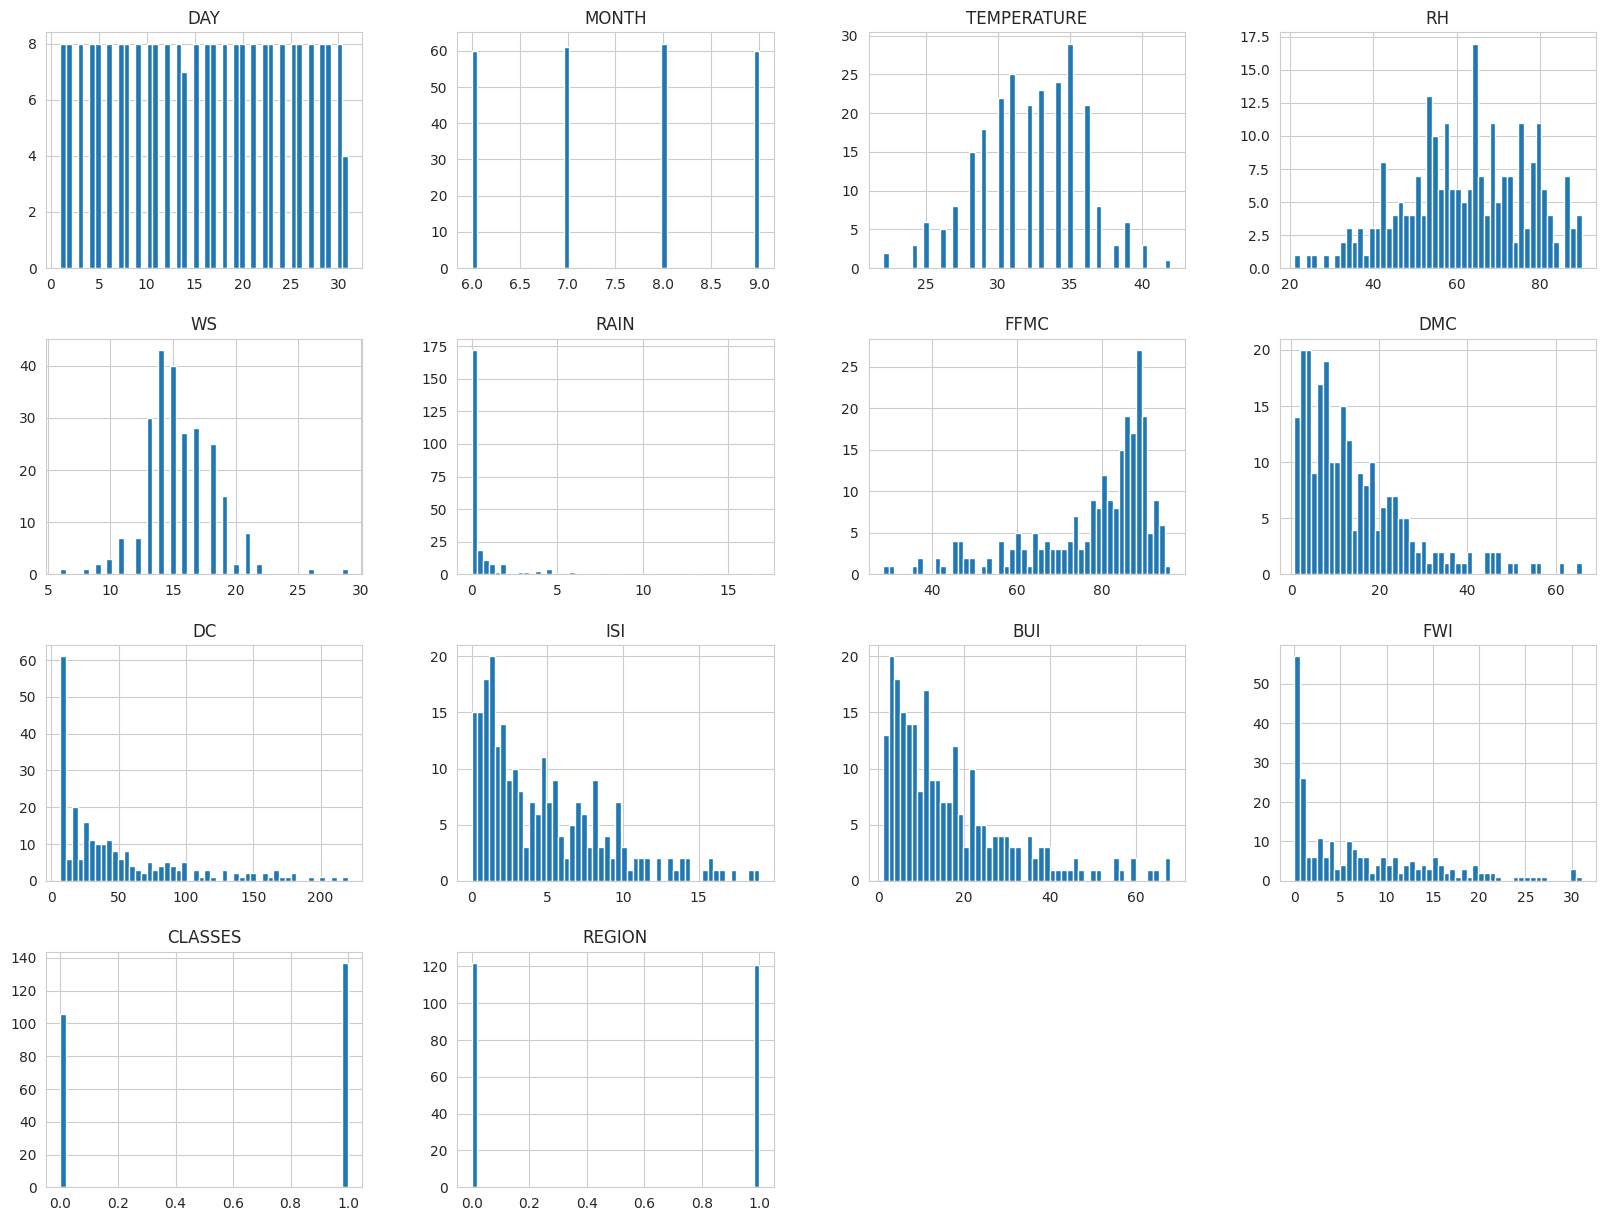

In [545]:
## Plot density plot for all features
data.hist(bins=50, figsize=(20, 15))
plt.show()

In [546]:
# check the propertion for each class value
percentage = data["CLASSES"].value_counts(normalize=True) * 100
percentage

,proportion
CLASSES,
1,56.378601
0,43.621399


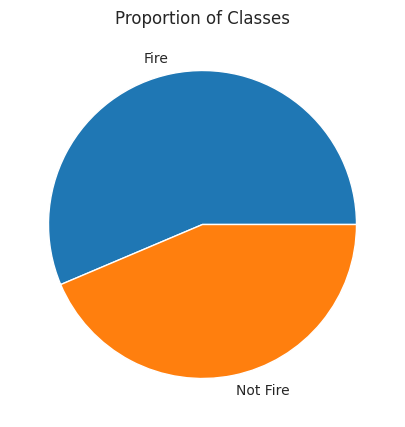

In [547]:
labels = ["Fire", "Not Fire"]
plt.figure(figsize=(10, 5))
plt.pie(percentage, labels=labels)
plt.title("Proportion of Classes")
plt.show()

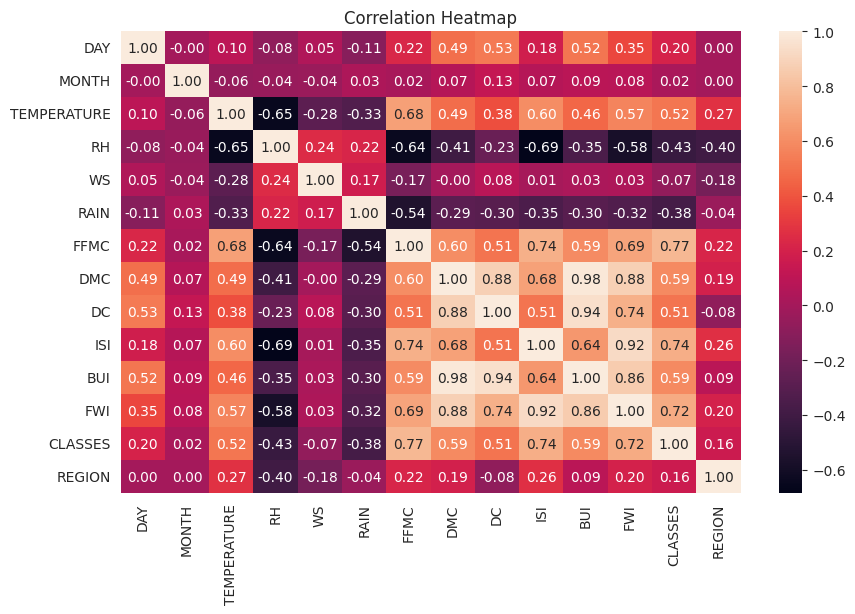

In [548]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Correlation Coefficient: The correlation coefficient, denoted as r, is a statistical measure that quantifies the strength and direction of the linear relationship between two variables. Its value ranges from -1 to +1.

Positive Correlation (0 < r ≤ 1): This indicates that as one variable increases, the other also increases. For example, height and weight tend to show a positive correlation; taller individuals often have higher weights.

Negative Correlation (-1 ≤ r < 0): This suggests that as one variable increases, the other decreases. An example is the relationship between the amount of gas in a car and the distance it can travel before needing a refill.

No Correlation (r == 0): Indicates that there is no linear relationship between the two variables.

Text(0.5, 1.0, 'Fire Analysis of Regions 1')

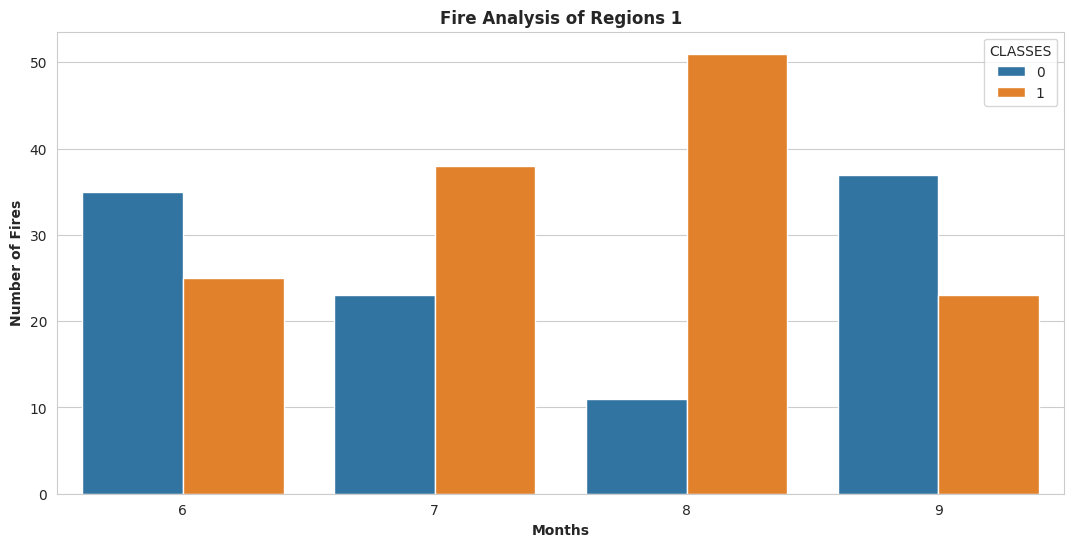

In [549]:
#fire analysis by month for region 1
df_temp = df.loc[data["REGION"]==1]
plt.subplots(figsize=(13, 6))
sns.set_style("whitegrid")
sns.countplot(x="MONTH", hue="CLASSES", data=data)
plt.ylabel("Number of Fires", weight="bold")
plt.xlabel("Months", weight="bold")
plt.title("Fire Analysis of Regions 1", weight="bold")

Text(0.5, 1.0, 'Fire Analysis of Regions 1')

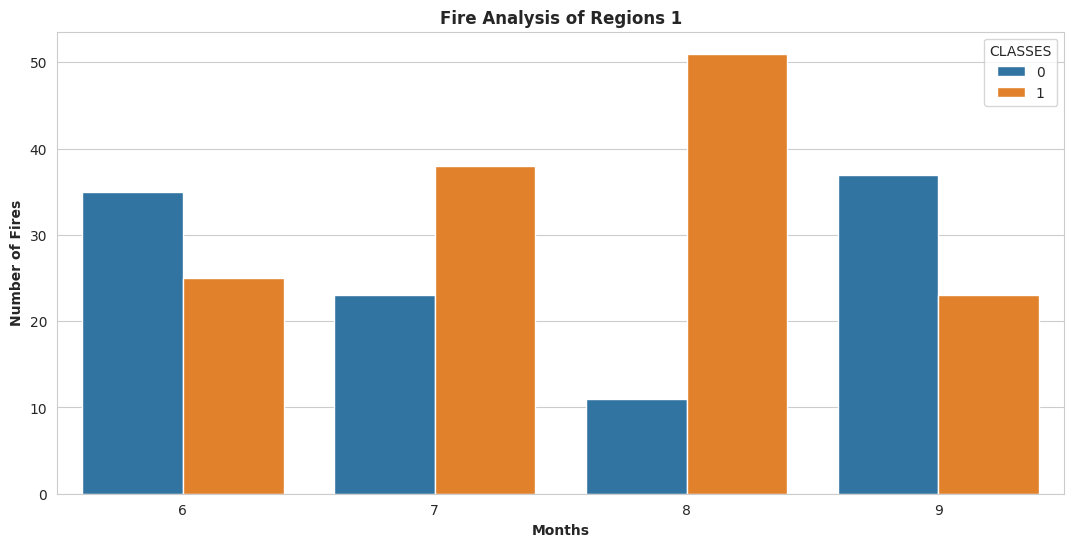

In [550]:
#fire analysis by month for region 0
df_temp = df.loc[data["REGION"]==0]
plt.subplots(figsize=(13, 6))
sns.set_style("whitegrid")
sns.countplot(x="MONTH", hue="CLASSES", data=data)
plt.ylabel("Number of Fires", weight="bold")
plt.xlabel("Months", weight="bold")
plt.title("Fire Analysis of Regions 1", weight="bold")

# Observation
* the majority of forest fires occurred in August and September across regions.
 From the plot of monthly data, a few key points can be noted:

* August experienced the highest number of fires.
* The most significant fire activity was concentrated in just three months: June, July, and August.
* Fewer fires were recorded in September.

In [551]:
# Model
# independent and dependent features
X=data.drop('FWI',axis=1)
y=data['FWI']

In [552]:
X.head()

,DAY,MONTH,TEMPERATURE,RH,WS,RAIN,FFMC,DMC,DC,ISI,BUI,CLASSES,REGION
0,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0,0
1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0,0
2,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0,0
3,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,0
4,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0,0


The dataset is typically divided into two sections: a training set and a testing set. A common split is 75% for training and 25% for testing, though this may vary based on the dataset's size and the analysis needs.

The model is trained using the training set, where it learns the patterns between the input features and the target variable.

After training, the model is assessed using the testing set, which helps gauge its performance on new, unseen data.

In [553]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [554]:
X_train.shape,X_test.shape

((182, 13), (61, 13))

In [555]:
# import and use StandardScaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [556]:
X_train_scaled

array([[-1.10036414,  1.3585682 , -0.84284248, ..., -0.77269802,
        -1.10431526, -0.98907071],
       [ 0.47831144, -1.34865164, -0.30175842, ..., -0.90344718,
        -1.10431526,  1.01105006],
       [-0.53655144,  0.45616158,  2.13311985, ...,  0.38339978,
         0.90553851,  1.01105006],
       ...,
       [-1.66417685,  1.3585682 , -1.9250106 , ..., -1.03419633,
        -1.10431526, -0.98907071],
       [ 1.49317432, -0.44624503,  0.50986767, ...,  0.18383528,
         0.90553851,  1.01105006],
       [-0.53655144,  1.3585682 , -0.57230045, ..., -0.99290713,
        -1.10431526, -0.98907071]])

#Building Model

In [557]:
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge,ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

linreg=LinearRegression()
linreg.fit(X_train_scaled,y_train)
y_pred=linreg.predict(X_test_scaled)

print('Linear Regression Performance:')
print("Mean absolute error: ", mean_absolute_error(y_test,y_pred))
print("R2 Score: ", r2_score(y_test,y_pred))

cv_scores_lin_reg = cross_val_score(linreg, X_train, y_train, cv=5, scoring='r2')
cv_scores_lin_reg

print(f'Mean Cross-Validation r2_score for Linear Regression: {np.mean(cv_scores_lin_reg)}')


Linear Regression Performance:
Mean absolute error:  0.475817573135746
R2 Score:  0.9892728563308907
Mean Cross-Validation r2_score for Linear Regression: 0.9543480774275892


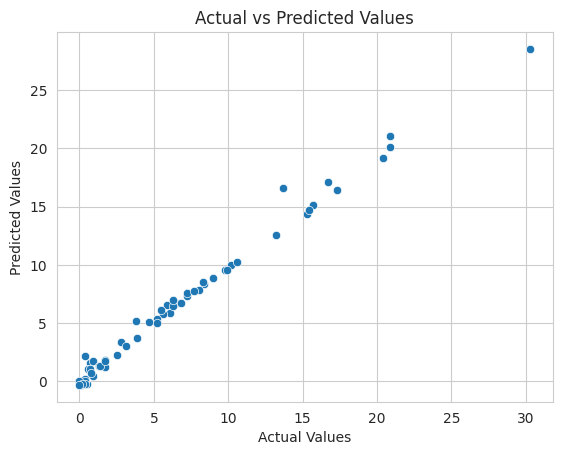

In [558]:
# actual vs predicted
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

In [559]:
## Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_reg = LinearRegression()
poly_reg.fit(X_poly_train, y_train)


# Predict on Polynomial Model
y_poly_train_pred = poly_reg.predict(X_poly_train)
y_poly_test_pred = poly_reg.predict(X_poly_test)

# Evaluation of Polynomial Regression Model
print('Polynomial Regression Performance:')
print("Mean absolute error: ", mean_absolute_error(y_train, y_poly_train_pred))
print("R2 Score: ", r2_score(y_test, y_poly_test_pred))

cv_scores_poly_lin_reg = cross_val_score(poly_reg, X_train, y_train, cv=5, scoring='r2')

print(f'Mean Cross-Validation r2_score for Polynomial Regression: {np.mean(cv_scores_poly_lin_reg)}')



Polynomial Regression Performance:
Mean absolute error:  0.20104498968019596
R2 Score:  0.9916221994650277
Mean Cross-Validation r2_score for Polynomial Regression: 0.9543480774275892


In [560]:
lasso=Lasso()
lasso.fit(X_train_scaled,y_train)
y_pred=lasso.predict(X_test_scaled)

print('lasso Regression Performance:')
print("Mean absolute error: ", mean_absolute_error(y_test,y_pred))
print("R2 Score: ", r2_score(y_test,y_pred))


cv_scores_laso_lin_reg = cross_val_score(lasso, X_train, y_train, cv=5, scoring='r2')

print(f'Mean Cross-Validation r2_score for Lasso Linear Regression: {np.mean(cv_scores_laso_lin_reg)}')


lasso Regression Performance:
Mean absolute error:  1.0816323220340065
R2 Score:  0.9548117073146738
Mean Cross-Validation r2_score for Lasso Linear Regression: 0.9557409257787285


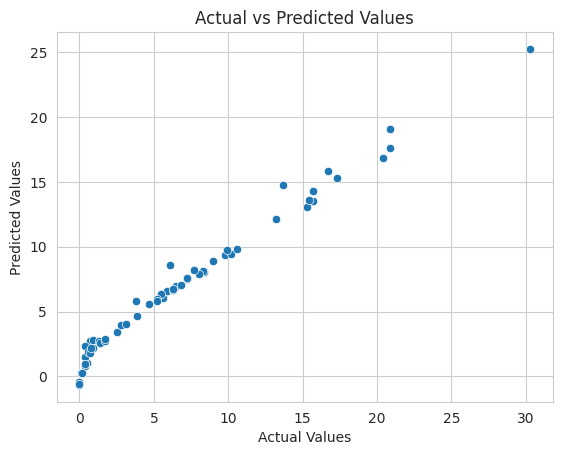

In [561]:
# actual vs predicted
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

In [562]:
ridge=Ridge()
ridge.fit(X_train_scaled,y_train)
y_pred=ridge.predict(X_test_scaled)



print('Ridge Regression Performance:')
print("Mean absolute error: ", mean_absolute_error(y_test,y_pred))
print("R2 Score: ", r2_score(y_test,y_pred))

cv_scores_ridge_lin_reg = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')

print(f'Mean Cross-Validation r2_score for Ridge Linear Regression: {np.mean(cv_scores_ridge_lin_reg)}')

Ridge Regression Performance:
Mean absolute error:  0.5122077781047932
R2 Score:  0.9870959622986031
Mean Cross-Validation r2_score for Ridge Linear Regression: 0.9545387759513412


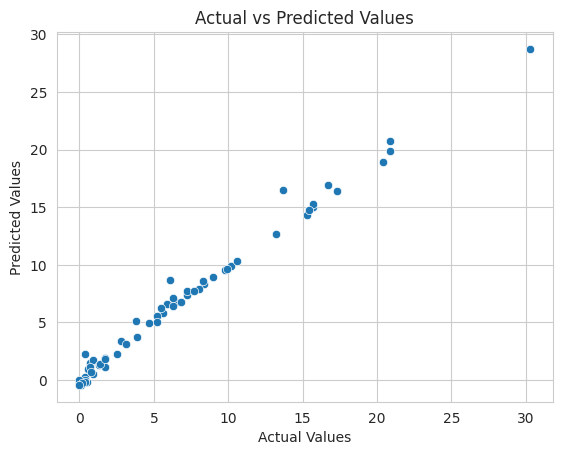

In [563]:
# actual vs predicted
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

In [564]:
elastic=ElasticNet()
elastic.fit(X_train_scaled,y_train)
y_pred=elastic.predict(X_test_scaled)

print('Elastic Regression Performance:')
print("Mean absolute error: ", mean_absolute_error(y_test,y_pred))
print("R2 Score: ", r2_score(y_test,y_pred))

cv_scores_elastic_reg = cross_val_score(elastic, X_train, y_train, cv=5, scoring='r2')
print(f'Mean Cross-Validation r2_score for Elastic net Linear Regression: {np.mean(cv_scores_elastic_reg)}')

Elastic Regression Performance:
Mean absolute error:  1.6831601751476268
R2 Score:  0.9006649049983614
Mean Cross-Validation r2_score for Elastic net Linear Regression: 0.9567828300759784


# cross-validation and hyperparameter tuning.

In [565]:
# set up grid search with cross validation for elasticNet
alpha_range = np.logspace(-2, 0.2, 20)  # range for alpha
l1_ratio_range = np.linspace(0, 1, 20)  # range for l1_ratio
param_grid = {"alpha": alpha_range, "l1_ratio": l1_ratio_range}
grid = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring="r2")

# fitting grid search model
grid.fit(X_train_scaled, y_train)

# check for the best parameter
print("Best parameters: ", grid.best_params_)

# Re-fit the ElasticNet model with the best parameters
best_elastic = ElasticNet(
    alpha=grid.best_params_["alpha"], l1_ratio=grid.best_params_["l1_ratio"]
)
best_elastic.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = best_elastic.predict(X_test_scaled)
elastic_mae = mean_absolute_error(y_test, y_pred)
elastic_score = r2_score(y_test, y_pred)
print("Mean absolute error: ", elastic_mae)
print("R2 Score: ", elastic_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+02, tolerance: 8.701e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e+02, tolerance: 8.272e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best parameters:  {'alpha': 0.049515006694731314, 'l1_ratio': 0.47368421052631576}
Mean absolute error:  0.6157754178147389
R2 Score:  0.9824910878966809


In [566]:
# Save the linear regression model as an example
pickle.dump(linreg,open('regression_model.pkl','wb'))
pickle.dump(poly_reg,open('polynomial_regression.pkl','wb'))
pickle.dump(lasso,open('lasso_regression_model.pkl','wb'))
pickle.dump(ridge,open('ridge_regression_model.pkl','wb'))
pickle.dump(elastic,open('elastic_net_regression_model.pkl','wb'))
pickle.dump(scaler,open('scaling.pkl','wb'))



# Prediction in new data

In [567]:
#new data prediction
X_pred=data.iloc[:1]
X_pred = np.array(X_pred.drop('FWI', axis=1))
# transformation of a new data
scaler.transform(X_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[-1.66417685, -1.34865164, -0.84284248, -0.35227576,  0.9200267 ,
        -0.38406017, -0.83345658, -0.89858211, -0.87086348, -0.81483447,
        -0.92409178, -1.10431526, -0.98907071]])

In [568]:
# predict with the new data
linreg.predict(scaler.transform(X_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.13047546])

# Loading pickeled models and predicting on the new data

In [569]:
# loading of the pickled model
pickled_model_lr=pickle.load(open('regression_model.pkl','rb'))
pickled_model_lr.predict(scaler.transform(X_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.13047546])

In [570]:
pickled_model_lr=pickle.load(open('lasso_regression_model.pkl','rb'))
pickled_model_lr.predict(scaler.transform(X_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1.12458886])

In [571]:
pickled_model_rg=pickle.load(open('ridge_regression_model.pkl','rb'))
pickled_model_rg.predict(scaler.transform(X_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.20569622])

In [572]:
pickled_model_en=pickle.load(open('elastic_net_regression_model.pkl','rb'))
pickled_model_en.predict(scaler.transform(X_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1.54355068])